True Q* (for reference):
 [[6.124 6.854]
 [6.354 6.181]
 [6.08  6.858]]
[Fed-DVR-Q] Epoch 1/12: error=4.7819, cum_bits=6120
[Fed-DVR-Q] Epoch 2/12: error=3.4391, cum_bits=12240
[Fed-DVR-Q] Epoch 3/12: error=2.4819, cum_bits=18360
[Fed-DVR-Q] Epoch 4/12: error=1.8141, cum_bits=24480
[Fed-DVR-Q] Epoch 5/12: error=1.2975, cum_bits=30600
[Fed-DVR-Q] Epoch 6/12: error=0.9596, cum_bits=36720
[Fed-DVR-Q] Epoch 7/12: error=0.7145, cum_bits=42840
[Fed-DVR-Q] Epoch 8/12: error=0.5309, cum_bits=48960
[Fed-DVR-Q] Epoch 9/12: error=0.3784, cum_bits=55080
[Fed-DVR-Q] Epoch 10/12: error=0.2675, cum_bits=61200
[Fed-DVR-Q] Epoch 11/12: error=0.1793, cum_bits=67320
[Fed-DVR-Q] Epoch 12/12: error=0.1344, cum_bits=73440
[Fed-DVR-Q] Epoch 1/12: error=4.7946, cum_bits=6120
[Fed-DVR-Q] Epoch 2/12: error=3.4478, cum_bits=12240
[Fed-DVR-Q] Epoch 3/12: error=2.4944, cum_bits=18360
[Fed-DVR-Q] Epoch 4/12: error=1.7993, cum_bits=24480
[Fed-DVR-Q] Epoch 5/12: error=1.3032, cum_bits=30600
[Fed-DVR-Q] Epoch 6/12: er

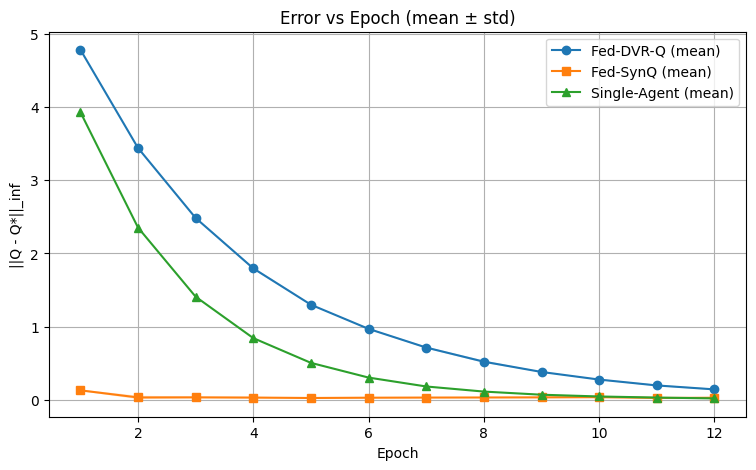

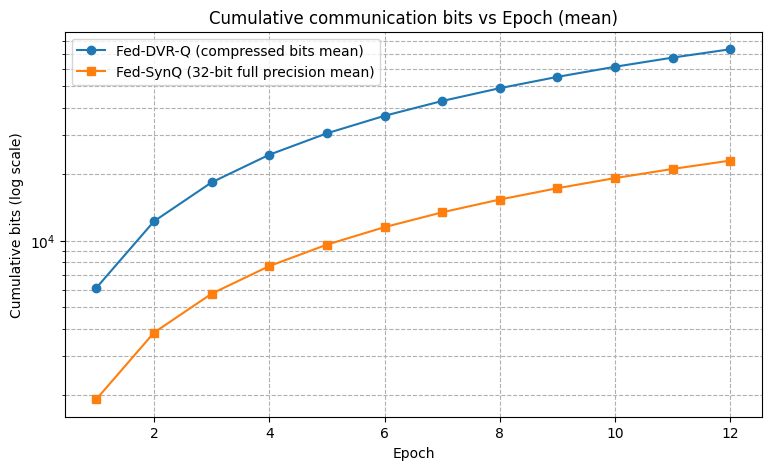


Final results (means over seeds):
Fed-DVR-Q final error: 0.1400, cumulative bits: 73440
Fed-SynQ final error: 0.0256, cumulative bits: 23040
Single-Agent final error: 0.0165


In [5]:
# Final Colab demo: Tuned Fed-DVR-Q vs Fed-SynQ vs Single-Agent (multi-seed averages)
# Paste this whole block into one Colab cell and run.

import numpy as np
import math
import matplotlib.pyplot as plt
import random
from copy import deepcopy
np.random.seed(0)
random.seed(0)

# ----------------------------- MDP definition (tabular) -----------------------------
S = 3   # number of states
A = 2   # number of actions
gamma = 0.9

P = np.zeros((S, A, S))
P[0,0] = [0.8,0.1,0.1]
P[0,1] = [0.1,0.7,0.2]
P[1,0] = [0.2,0.7,0.1]
P[1,1] = [0.1,0.2,0.7]
P[2,0] = [0.6,0.2,0.2]
P[2,1] = [0.25,0.25,0.5]

R = np.zeros((S, A))
R[0,0] = 0.0; R[0,1] = 1.0
R[1,0] = 0.5; R[1,1] = 0.1
R[2,0] = 0.0; R[2,1] = 0.8

def value_iteration(P, R, gamma, tol=1e-8, max_iter=10000):
    S, A, _ = P.shape
    Q = np.zeros((S,A))
    for it in range(max_iter):
        Q_old = Q.copy()
        for s in range(S):
            for a in range(A):
                Q[s,a] = R[s,a] + gamma * np.dot(P[s,a], np.max(Q_old, axis=1))
        if np.max(np.abs(Q - Q_old)) < tol:
            break
    return Q

Q_star = value_iteration(P, R, gamma)
print("True Q* (for reference):\n", np.round(Q_star,3))

# ----------------------------- Simulator / generative model -----------------------------
def sample_transition(s, a):
    next_state = np.random.choice(S, p=P[s,a])
    reward = R[s,a]
    return next_state, reward

def sample_bellman_operator(Q, num_samples_per_sa=1):
    """Estimate T Q by sampling num_samples_per_sa next-states for each (s,a)."""
    T_hat = np.zeros_like(Q)
    for s in range(S):
        for a in range(A):
            vals = []
            for _ in range(num_samples_per_sa):
                ns, r = sample_transition(s,a)
                vals.append(r + gamma * np.max(Q[ns]))
            T_hat[s,a] = np.mean(vals)
    return T_hat

# ----------------------------- Compressor: stochastic quantization -----------------------------
def stochastic_quantize(vec, D, J):
    """Stochastic unbiased-like quantizer (illustrative).
       vec: 1D numpy vector
       D: bound on magnitude (use 1/(1-gamma))
       J: bits per coordinate (levels = 2^J)
       returns quantized vector and bits used
    """
    vec = np.asarray(vec).astype(float)
    levels = 2**J
    if J == 0:
        return np.zeros_like(vec), 0
    edges = np.linspace(-D, D, levels+1)
    centers = 0.5*(edges[:-1] + edges[1:])
    q = np.zeros_like(vec)
    total_bits = vec.size * J
    for i, v in enumerate(vec):
        v_clipped = float(np.clip(v, -D, D))
        if v_clipped <= centers[0]:
            q[i] = centers[0]
        elif v_clipped >= centers[-1]:
            q[i] = centers[-1]
        else:
            idx = np.searchsorted(centers, v_clipped)
            if centers[idx] == v_clipped:
                q[i] = centers[idx]
            else:
                up = centers[idx]
                low = centers[idx-1]
                p_up = (v_clipped - low) / (up - low)
                q[i] = up if np.random.rand() < p_up else low
    return q, total_bits

# ----------------------------- Single-agent baseline (batched Q) -----------------------------
def single_agent_q(total_samples_per_epoch=5000, epochs=12):
    Q = np.zeros((S,A))
    errors = []
    for k in range(epochs):
        # approximate a few batch updates using total_samples_per_epoch
        samples_per_sa = max(1, int(total_samples_per_epoch / (S*A)))
        for _ in range(10):
            Tb = sample_bellman_operator(Q, num_samples_per_sa=samples_per_sa)
            Q = 0.5 * Q + 0.5 * Tb
        errors.append(np.max(np.abs(Q - Q_star)))
    return {'Q_final': Q, 'errors': errors}

# ----------------------------- Fed-SynQ baseline (simplified) -----------------------------
def fed_syn_q(num_agents=5, epochs=12, T_local=80, B=64):
    bits_per_coordinate = 32  # assume full-precision 32-bit float
    Q_agents = [np.zeros((S,A)) for _ in range(num_agents)]
    Q_global = np.zeros((S,A))
    comm_bits_cumulative = []
    comm_bits_total = 0
    errors = []
    for k in range(epochs):
        # local updates
        for m in range(num_agents):
            Q_local = Q_agents[m]
            for t in range(T_local):
                Tb = sample_bellman_operator(Q_local, num_samples_per_sa=max(1, B//S))
                alpha = 0.5
                Q_local = (1 - alpha) * Q_local + alpha * Tb
            Q_agents[m] = Q_local
        # communication: agents send full diffs to server
        for m in range(num_agents):
            diff = (Q_agents[m] - Q_global).ravel()
            comm_bits_total += diff.size * bits_per_coordinate
        # server averages
        Q_global = sum(Q_agents) / num_agents
        # server broadcasts global to agents (count broadcast)
        comm_bits_total += num_agents * Q_global.ravel().size * bits_per_coordinate
        for m in range(num_agents):
            Q_agents[m] = Q_global.copy()
        errors.append(np.max(np.abs(Q_global - Q_star)))
        comm_bits_cumulative.append(comm_bits_total)
    return {'Q_final': Q_global, 'errors': errors, 'comm_bits': comm_bits_cumulative}

# ----------------------------- Fed-DVR-Q simplified (tuned) -----------------------------
def fed_dvr_q(num_agents=5, epochs=12, I=16, B=64, L=1024, J=12, D=None, learning_rate=0.2):
    SA = S * A
    Q_global = np.zeros((S,A))
    comm_bits_cumulative = []
    comm_bits_total = 0
    if D is None:
        D = 1.0 / (1 - gamma)  # safe bound
    errors = []

    def compute_TeL(Q):
        nonlocal comm_bits_total
        per_agent_samples = int(np.ceil(L / num_agents))
        Te_m_list = []
        for m in range(num_agents):
            Te_m = sample_bellman_operator(Q, num_samples_per_sa=per_agent_samples)
            diff = (Te_m - Q).ravel()
            qdiff, bits = stochastic_quantize(diff, D, J)
            comm_bits_total += bits
            Te_m_list.append(qdiff.reshape(S,A) + Q)
        TeL_est = sum(Te_m_list) / num_agents
        return TeL_est

    def RefineEstimate(Q_in):
        nonlocal comm_bits_total
        TeL = compute_TeL(Q_in)
        Qi = Q_in.copy()
        for i in range(I):
            updates = []
            for m in range(num_agents):
                Tb_Qi_minus1 = sample_bellman_operator(Qi, num_samples_per_sa=max(1, B//S))
                Tb_Q_ref = sample_bellman_operator(Q_in, num_samples_per_sa=max(1, B//S))
                local_update = (1 - learning_rate) * Qi + learning_rate * (Tb_Qi_minus1 - Tb_Q_ref + TeL)
                diff = (local_update - Qi).ravel()
                qdiff, bits = stochastic_quantize(diff, D, J)
                comm_bits_total += bits
                updates.append(qdiff.reshape(S,A) + Qi)
            Qi = sum(updates) / num_agents
        return Qi

    for k in range(epochs):
        Q_global = RefineEstimate(Q_global)
        err = np.max(np.abs(Q_global - Q_star))
        errors.append(err)
        comm_bits_cumulative.append(comm_bits_total)
        # optional quick print for monitoring (comment out if verbose)
        print(f"[Fed-DVR-Q] Epoch {k+1}/{epochs}: error={err:.4f}, cum_bits={comm_bits_total}")
    return {'Q_final': Q_global, 'errors': errors, 'comm_bits': comm_bits_cumulative}

# ----------------------------- Multi-seed runner & plotting -----------------------------
def run_all_tuned(seeds=[0,1,2], num_agents=5, epochs=12):
    all_dvr_err = []
    all_syn_err = []
    all_single_err = []
    all_dvr_bits = []
    all_syn_bits = []
    for s in seeds:
        np.random.seed(s); random.seed(s)
        dvr = fed_dvr_q(num_agents=num_agents, epochs=epochs, I=16, B=64, L=1024, J=12, D=None, learning_rate=0.2)
        syn = fed_syn_q(num_agents=num_agents, epochs=epochs, T_local=80, B=64)
        single = single_agent_q(total_samples_per_epoch=num_agents*(1024 + 16*64), epochs=epochs)
        all_dvr_err.append(dvr['errors'])
        all_dvr_bits.append(dvr['comm_bits'])
        all_syn_err.append(syn['errors'])
        all_syn_bits.append(syn['comm_bits'])
        all_single_err.append(single['errors'])
    return (np.array(all_dvr_err), np.array(all_dvr_bits),
            np.array(all_syn_err), np.array(all_syn_bits),
            np.array(all_single_err))

# Choose seeds and run
seeds = [0,1,2]
dvr_err_arr, dvr_bits_arr, syn_err_arr, syn_bits_arr, single_err_arr = run_all_tuned(seeds=seeds, num_agents=5, epochs=12)

# Compute mean and std
dvr_err_mean, dvr_err_std = dvr_err_arr.mean(axis=0), dvr_err_arr.std(axis=0)
syn_err_mean, syn_err_std = syn_err_arr.mean(axis=0), syn_err_arr.std(axis=0)
single_err_mean, single_err_std = single_err_arr.mean(axis=0), single_err_arr.std(axis=0)

dvr_bits_mean = dvr_bits_arr.mean(axis=0)
syn_bits_mean = syn_bits_arr.mean(axis=0)

# Plot error curves (mean ± std)
epochs = np.arange(1, dvr_err_mean.size+1)
plt.figure(figsize=(9,5))
plt.plot(epochs, dvr_err_mean, marker='o', label='Fed-DVR-Q (mean)')
plt.fill_between(epochs, dvr_err_mean-dvr_err_std, dvr_err_mean+dvr_err_std, alpha=0.2)
plt.plot(epochs, syn_err_mean, marker='s', label='Fed-SynQ (mean)')
plt.fill_between(epochs, syn_err_mean-syn_err_std, syn_err_mean+syn_err_std, alpha=0.2)
plt.plot(epochs, single_err_mean, marker='^', label='Single-Agent (mean)')
plt.fill_between(epochs, single_err_mean-single_err_std, single_err_mean+single_err_std, alpha=0.2)
plt.xlabel('Epoch'); plt.ylabel('||Q - Q*||_inf'); plt.title('Error vs Epoch (mean ± std)'); plt.grid(True); plt.legend()
plt.show()

# Plot cumulative communication bits (log scale)
plt.figure(figsize=(9,5))
plt.plot(epochs, dvr_bits_mean, marker='o', label='Fed-DVR-Q (compressed bits mean)')
plt.plot(epochs, syn_bits_mean, marker='s', label='Fed-SynQ (32-bit full precision mean)')
plt.yscale('log')
plt.xlabel('Epoch'); plt.ylabel('Cumulative bits (log scale)')
plt.title('Cumulative communication bits vs Epoch (mean)')
plt.grid(True, which='both', ls='--'); plt.legend()
plt.show()

# Print final summary
print("\nFinal results (means over seeds):")
print(f"Fed-DVR-Q final error: {dvr_err_mean[-1]:.4f}, cumulative bits: {dvr_bits_mean[-1]:.0f}")
print(f"Fed-SynQ final error: {syn_err_mean[-1]:.4f}, cumulative bits: {syn_bits_mean[-1]:.0f}")
print(f"Single-Agent final error: {single_err_mean[-1]:.4f}")
